In [1]:
import os
import random
import tempfile
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import jpeglib
jpeglib.version.set("6b")
import cv2
import numpy as np

from pathlib import Path
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import AgglomerativeClustering

# Margin effects

The JPEG DCT algorithm works with blocks of the dimensions 8x8. 
As long as the image dimensions are multiples of 8, everything is aligned and DCT works as intended.
For other images with dimensions which are not multiples of 8,  DCT blocks on the edges are incomplete / partially full. They contain fractions of pixles. (half of it is invalid, part of the blocks are outside of the image).
The hypothesis of this experiment is that different jpeglib versions might handle this cases differently. 

The number of rows and columns in an incomplet block is based on the modulo of the image dimensions.
In order to test this, we choose height and weight of our input images to exhaust all possible modulos in both dimensions.

The structure of this notebook is as follows:

    - Loading Datasets
    - Helper functions

    1. Systematic Cropping - Alaska2 Dataset
        a. Compression
        b. Decompression
    2. Systematic Cropping with chroma Subsampling - Alaska2 Dataset
        a. Compression
        b. Decompression
    

## Datasets ALASKA & BOSSbase

In [2]:
random.seed(12345)
N_samples = 10

# checkerboard
import numpy as np
def checkerboard(boardsize, tilesize, channels=3):
    board = np.zeros([*boardsize, channels], dtype=np.uint8)
    for i in range(boardsize[0]):
        for j in range(boardsize[1]):
            if (i//tilesize[0]) % 2 == (j//tilesize[1]) % 2:
                board[i,j] = 255
    return board

In [3]:
# Load ALASKA2 database
alaska_path = Path.home() / 'Datasets' / 'ALASKA_v2_TIFF_256_COLOR'#'alaska2-image-steganalysis' / 'Cover'
alaska_names = [alaska_path / f for f in os.listdir(alaska_path)]
print("Loaded ALASKA2 database with", len(alaska_names), "images.")
random.seed(42) # answer to everything
alaska_names_sub = random.sample(alaska_names, N_samples-2)

Loaded ALASKA2 database with 80004 images.


In [4]:
# choose most and least saturated
import matplotlib.pyplot as plt
# most,least = (None,0),(None,0)
# for i,f in enumerate(alaska_names):
#    if i % 500 == 0: print(i, '/', len(alaska_names), '         ', end='\r')
# if str(f).split('.')[-1] != 'tif': continue
#    x = plt.imread(str(f))
#    xmin,xmax = (x == 0).sum(),(x == 255).sum()
#    if xmin > least[1]: least = (f,xmin)
#    if xmax > most[1]: most = (f,xmax)
most,least = (alaska_path / '10343.tif',98491),(alaska_path / '05887.tif', 78128)
# add them
alaska_names_sub.append(most[0])
alaska_names_sub.append(least[0])

# load the image with PIL
import matplotlib.pyplot as plt
alaska = np.array([plt.imread(f) for f in alaska_names_sub])

# append checkerboard
for tilesize in [(4,4),(7,7),(8,8),(15,15),(16,16)]:
    alaska = np.append(alaska, np.expand_dims(checkerboard((256, 256), tilesize, 3), 0), 0)

print("Input shape", alaska.shape)

Input shape (15, 256, 256, 3)


In [5]:
# list BOSS database
boss_path = Path.home() / 'Datasets' / 'BOSS_raw' / 'BOSS_from_raw'
boss_names = [boss_path / f for f in os.listdir(boss_path)]
print("Loaded BOSS database with", len(boss_names), "images.")

# sample without replacement
import random
random.seed(42) # answer to everything
boss_names_sub = random.sample(boss_names, N_samples-2)

# choose most and least saturated
#import cv2
#most,least = (None,0),(None,0)
#for i,f in enumerate(boss_names):
#    if i % 500 == 0: print(i, '/', len(boss_names), '         ', end='\r')
#    if str(f).split('.')[-1] != 'png': continue
#    x = cv2.imread(str(f),cv2.IMREAD_GRAYSCALE)
#    xmin,xmax = (x == 0).sum(),(x == 255).sum()
#    if xmin > least[1]: least = (f,xmin)
#    if xmax > most[1]: most = (f,xmax)
most,least = (boss_path / '6900_1_3.png',262144),(boss_path / '6155_1_6.png', 88944)
# add them
boss_names_sub.append(most[0])
boss_names_sub.append(least[0])

# load the grayscale image with cv2
boss = np.array([np.array(cv2.imread(str(f),cv2.IMREAD_GRAYSCALE)) for f in boss_names_sub])
boss = np.expand_dims(boss, axis=3)

# append checkerboard
for tilesize in [(4,4),(7,7),(8,8),(15,15),(16,16)]:
    boss = np.append(boss, np.expand_dims(checkerboard((512, 512), tilesize, channels=1), 0), 0)

print("Input shape", boss.shape)

Loaded BOSS database with 23152 images.
Input shape (15, 512, 512, 1)


In [6]:
def compare_versions(D_dyn):
    missed_comp = {'v1': [], 'v2': [], 'offset1': [], 'offset2': [],'D': []}
    for i,v1 in enumerate(versions):
        for v2 in versions[i:]:
            for offset1 in offsets:
                for offset2 in offsets:
                    missed_comp['v1'].append(v1)
                    missed_comp['v2'].append(v2)
                    missed_comp['offset1'].append(offset1)
                    missed_comp['offset2'].append(offset2)
                    missed_comp['D'].append(D_dyn[v1][v2][offset1][offset2] * 100)
    return missed_comp

def plot_dist_heatmap(distmat):
    fig,ax = plt.subplots(1,1)
    sns.heatmap(
        pd.DataFrame(distmat == 0, index=versions, columns=versions),
        linewidth=.05, ax=ax, cmap=['lightsalmon','lightgreen'])
    colorbar = ax.collections[0].colorbar 
    r = colorbar.vmax - colorbar.vmin 
    colorbar.set_ticks([colorbar.vmin + r / 2 * (0.5 + i) for i in range(2)])
    colorbar.set_ticklabels(['mismatch','match'])
    
    plt.show()


def convert_to_distmat(offsets, images_rgb_c):
    # distance metric (based on L1)
    pixel_mismatch = lambda x1,x2: (np.abs(x1.astype(np.int32) - x2.astype(np.int32)) != 0).mean()

    # images to distance matrix
    distmats_rgb_offset = {offset:{} for offset in offsets}
    for offset1 in offsets:
        for offset2 in offsets:
            images_rgb_c_offset = images_rgb_c[
                (images_rgb_c.offset1 == offset1)&
                (images_rgb_c.offset2 == offset2)]


            images_rgb_c_list = np.array(
                [list(i) for i in images_rgb_c_offset.image.to_list()], dtype=object)
            images_rgb_c_list = images_rgb_c_list.reshape(len(versions), -1)
            dists_rgb_c = pdist(images_rgb_c_list, pixel_mismatch)
            distmat_rgb_c = squareform(dists_rgb_c)

            distmats_rgb_offset[offset1][offset2] = distmat_rgb_c
            
    return distmats_rgb_offset

def plot_mismatching_offsets(distmats):
    print_none = True
    
    for offset1 in distmats:
        for offset2 in distmats[offset1]:
            if (distmats[offset1][offset2] != 0).any():
                print_none = False
                print("offset1:", offset1, "offset2:", offset2)
                plot_dist_heatmap(distmats[offset1][offset2])
                
    if print_none:
        print("No mismatching offsets.")
        

def clustering(distmats_rgb_offset):
    # cluster in spatial domain by sampling factor
    
    print_none = True
    for offset1 in distmats_rgb_offset:
        for offset2 in distmats_rgb_offset[offset1]:
            for k in range(1,14):
                agnes = AgglomerativeClustering(n_clusters=k, linkage='average', affinity='precomputed')
                agnes.fit(distmats_rgb_offset[offset1][offset2])

                # compute heterogenity metric (sum of distances)
                heterogenity = np.sum([distmats_rgb_offset[offset1][offset2][i,j]
                         for group in np.unique(agnes.labels_)
                         for i in np.where(agnes.labels_ == group)[0]
                         for j in np.where(agnes.labels_ == group)[0] ])

                # homogenous clusters
                if heterogenity == 0: break
            print("offset1:", offset1, "offset2:", offset2)
            if k > 1:        
                print(" ->", k, "classes:", *[[versions[i] for i in np.where(agnes.labels_ == cl)[0]]
                                              for cl in np.unique(agnes.labels_)])
                print_none = False


### 1. Systematic cropping - Alaska2 
#### 1.a Compression without chroma subsampling

We started by cropping 10 test images to 256 and offsets of 8, 7, 4, 2, and 1.
After that we compressed the images with all available jpeg versions and decompressed with verson 9d, since earlier results demonstrated (...).

In [7]:
height_width = 256

In [8]:
offsets = np.array([8,7,4,2,1])+height_width
versions = ['6b','turbo210','7','8','8a','8b','8c','8d','9','9a','9b','9c','9d','9e']
kw = {'samp_factor': ((1,1),(1,1),(1,1)), 'qt': 75, 'flags': ['DO_FANCY_UPSAMPLING']} # sampling factor

## ALASKA

In [9]:
# iterate over all versions and crop images 
images_rgb_c = {'version': [], 'offset1': [],'offset2':[], 'image': []}

with tempfile.TemporaryDirectory() as tmp:
    
    # iterate versions
    for i,v_compress in enumerate(versions):
        
        # iterate offsets
        for offset1 in offsets:
            for offset2 in offsets:
                
                # cropping images 
                # alaska_cropped = alaska[:, :offset1, :offset2] #will be 10:offset:offset:3
                
                # cropp image from center
                center = tuple(s/2 for s in alaska.shape)
                x = int(center[2] - height_width/2)
                y = int(center[1] - height_width/2)
                alaska_cropped = alaska[:, y:y+offset1, x:offset2]
                
                alaska_path
                
                # compressing each cropped image with version
                fnames = [str(Path(tmp) / f'{i}.jpeg') for i in range(alaska.shape[0])]
                with jpeglib.version(v_compress):
                    for i,fname in enumerate(fnames):
                        
                        [jpeglib.JPEG().write_spatial(fname,alaska_cropped[i],**kw) 
                         for i,fname in enumerate(fnames)]


                # decompress with single (arbitrary) version
                with jpeglib.version('9d'):
                    images_rgb_c['version'].append(v_compress)
                    images_rgb_c['offset1'].append(offset1)
                    images_rgb_c['offset2'].append(offset2)
                    images_rgb_c['image'].append(np.array([
                        jpeglib.JPEG(fname).read_spatial(flags=['DO_FANCY_UPSAMPLING']) for fname in fnames
                    ]))
                    

TypeError: __init__() missing 9 required positional arguments: 'path', 'content', 'height', 'width', 'block_dims', 'samp_factor', 'jpeg_color_space', 'markers', and 'progressive_mode'

offset1: 264 offset2: 264


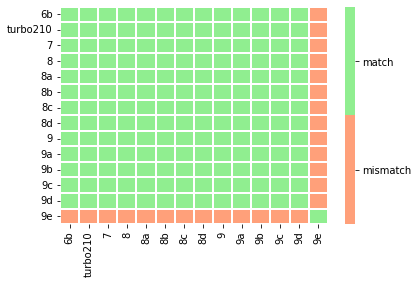

offset1: 264 offset2: 263


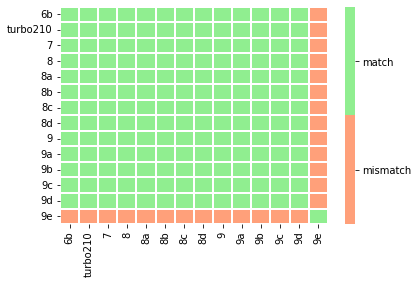

offset1: 264 offset2: 260


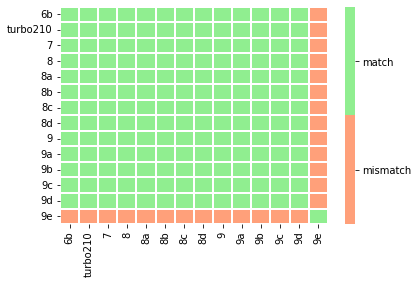

offset1: 264 offset2: 258


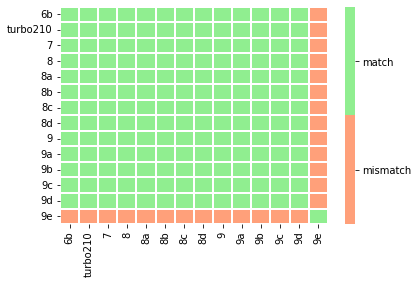

offset1: 264 offset2: 257


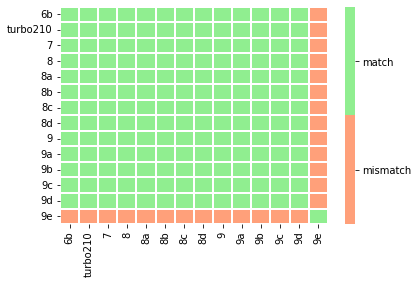

offset1: 263 offset2: 264


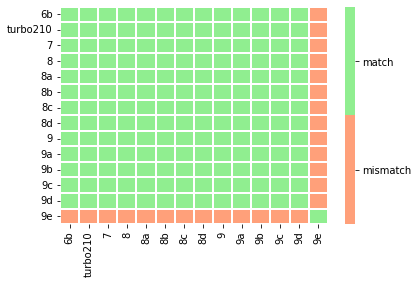

offset1: 263 offset2: 263


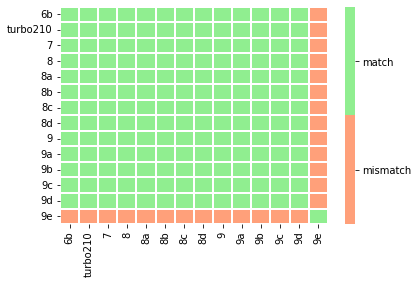

offset1: 263 offset2: 260


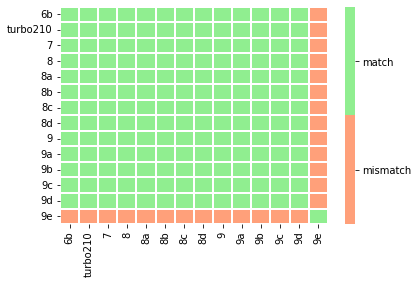

offset1: 263 offset2: 258


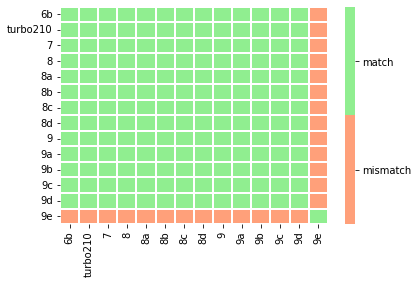

offset1: 263 offset2: 257


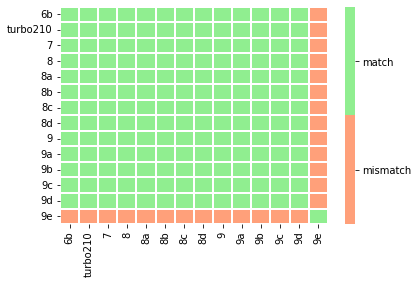

offset1: 260 offset2: 264


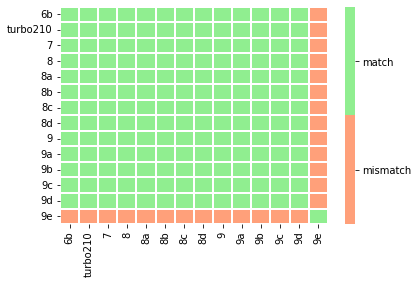

offset1: 260 offset2: 263


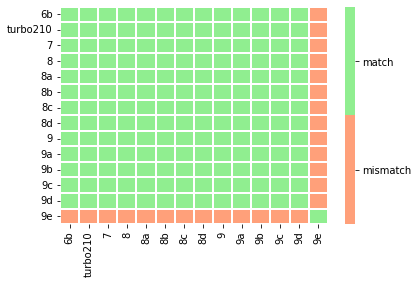

offset1: 260 offset2: 260


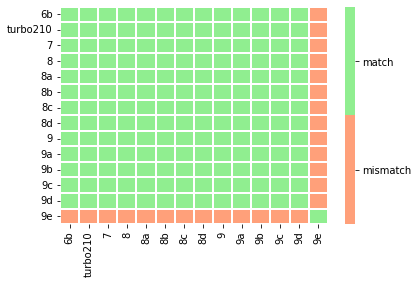

offset1: 260 offset2: 258


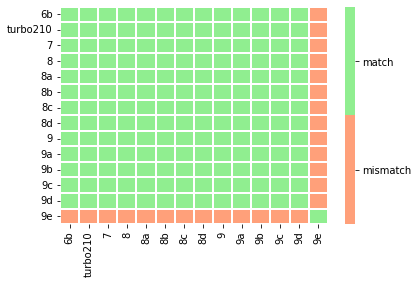

offset1: 260 offset2: 257


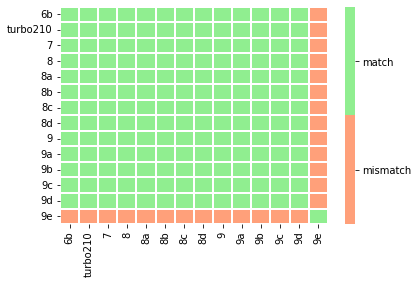

offset1: 258 offset2: 264


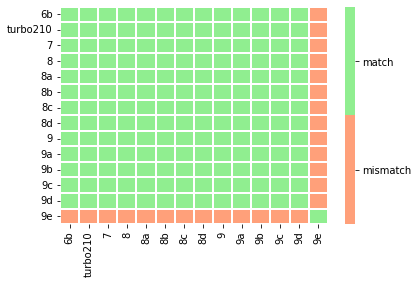

offset1: 258 offset2: 263


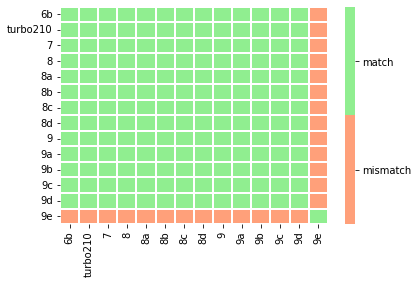

offset1: 258 offset2: 260


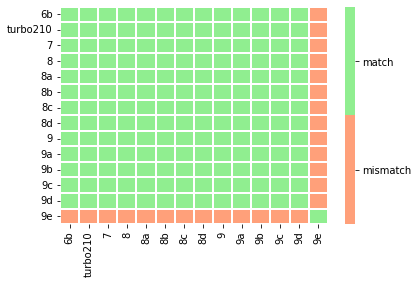

offset1: 258 offset2: 258


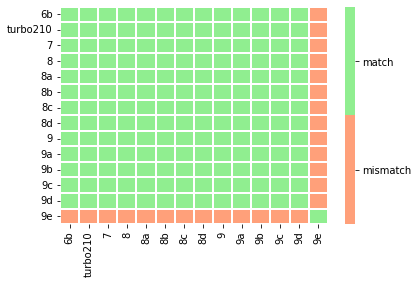

offset1: 258 offset2: 257


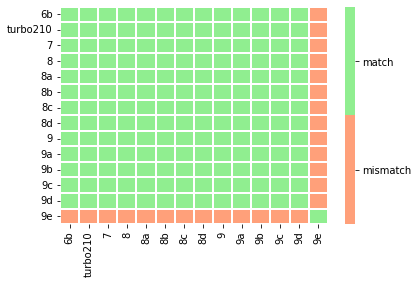

offset1: 257 offset2: 264


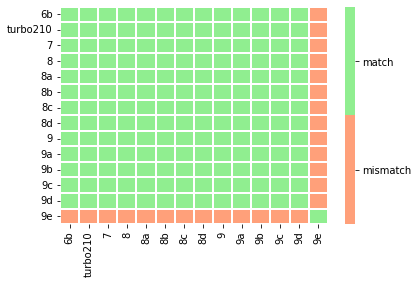

offset1: 257 offset2: 263


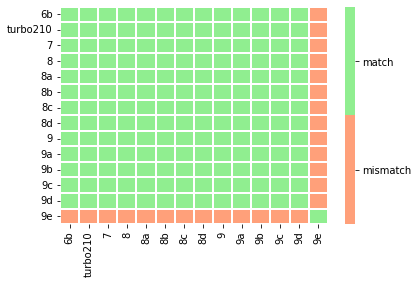

offset1: 257 offset2: 260


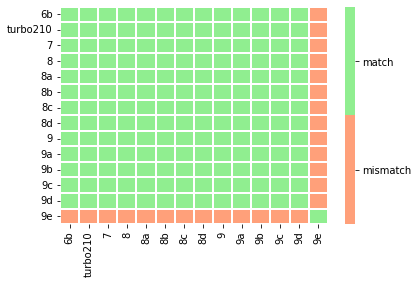

offset1: 257 offset2: 258


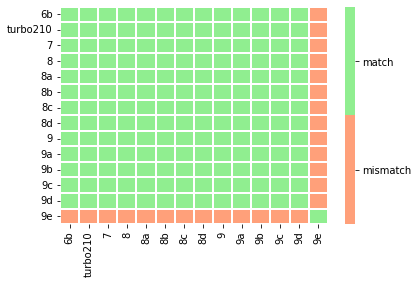

offset1: 257 offset2: 257


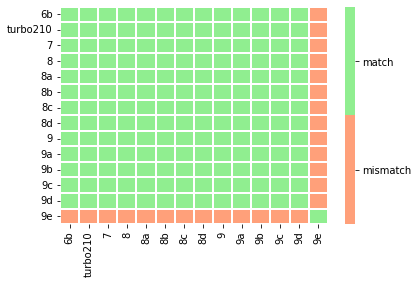

offset1: 264 offset2: 264
 -> 2 classes: ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['9e']
offset1: 264 offset2: 263
 -> 2 classes: ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['9e']
offset1: 264 offset2: 260
 -> 2 classes: ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['9e']
offset1: 264 offset2: 258
 -> 2 classes: ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['9e']
offset1: 264 offset2: 257
 -> 2 classes: ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['9e']
offset1: 263 offset2: 264
 -> 2 classes: ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['9e']
offset1: 263 offset2: 263
 -> 2 classes: ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['9e']
offset1: 263 offset2: 260
 -> 2 classes: ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8

In [10]:
# cast to dataframe
images_rgb_c = pd.DataFrame(images_rgb_c)

# convert to distance matrix
distmats_rgb_offset = convert_to_distmat(offsets, images_rgb_c)

# plot mismatching offsets
plot_mismatching_offsets(distmats_rgb_offset) 

# cluster offsets
clustering(distmats_rgb_offset)

## BOSS

In [11]:
kw = {'in_color_space': 'JCS_GRAYSCALE', 'qt': 75}

In [12]:
# iterate over all versions and crop images 
images_gs_c = {'version': [], 'offset1': [],'offset2':[], 'image': []}

with tempfile.TemporaryDirectory() as tmp:
    
    # iterate versions
    for i,v_compress in enumerate(versions):
        
        # iterate offsets
        for offset1 in offsets:
            for offset2 in offsets:
                
                # cropping images 
                # boss_cropped = np.ascontiguousarray(boss[:, :offset1, :offset2]) #will be 10:offset:offset:3
                
                 # cropp image from center
                center = tuple(s/2 for s in boss.shape)
                x = int(center[2] - height_width/2)
                y = int(center[1] - height_width/2)
                boss_cropped = np.ascontiguousarray(boss[:, y:y+offset1, x:offset2])
                
                # compressing each cropped image with version
                fnames = [str(Path(tmp) / f'{i}.jpeg') for i in range(boss.shape[0])]
                with jpeglib.version(v_compress):                                            
                        [jpeglib.JPEG().write_spatial(fname,boss_cropped[i],**kw) 
                         for i,fname in enumerate(fnames)]


                # decompress with single (arbitrary) version
                with jpeglib.version('9d'):
                    images_gs_c['version'].append(v_compress)
                    images_gs_c['offset1'].append(offset1)
                    images_gs_c['offset2'].append(offset2)
                    images_gs_c['image'].append(np.array([
                        jpeglib.JPEG(fname).read_spatial() for fname in fnames
                    ]))
                    

In [13]:
# cast to dataframe
images_gs_c = pd.DataFrame(images_gs_c)

# convert to distance matrix
distmats_gs_offset = convert_to_distmat(offsets, images_gs_c)

# plot mismatching offsets
plot_mismatching_offsets(distmats_gs_offset) 

# cluster offsets
clustering(distmats_gs_offset)

No mismatching offsets.
offset1: 264 offset2: 264
offset1: 264 offset2: 263
offset1: 264 offset2: 260
offset1: 264 offset2: 258
offset1: 264 offset2: 257
offset1: 263 offset2: 264
offset1: 263 offset2: 263
offset1: 263 offset2: 260
offset1: 263 offset2: 258
offset1: 263 offset2: 257
offset1: 260 offset2: 264
offset1: 260 offset2: 263
offset1: 260 offset2: 260
offset1: 260 offset2: 258
offset1: 260 offset2: 257
offset1: 258 offset2: 264
offset1: 258 offset2: 263
offset1: 258 offset2: 260
offset1: 258 offset2: 258
offset1: 258 offset2: 257
offset1: 257 offset2: 264
offset1: 257 offset2: 263
offset1: 257 offset2: 260
offset1: 257 offset2: 258
offset1: 257 offset2: 257


In [14]:
images_gs_c[['version','offset1','offset2']]

,version,offset1,offset2
0,6b,264,264
1,6b,264,263
2,6b,264,260
3,6b,264,258
4,6b,264,257
...,...,...,...
345,9e,257,264
346,9e,257,263
347,9e,257,260
348,9e,257,258


#### No Mismatches
We can see that compression without chroma subsampling does not produce differences. 
For completeness we will execute the same experiment by compressing using 9d jpeglib version and decompressing all available versions.


#### 1.b Decompression without chroma subsampling
Now let's check if we produce differences when decompressing with all available jpeglib versions. 

In [15]:
offsets = np.array([8,7,4,2,1]) + height_width
versions = ['6b','turbo210','7','8','8a','8b','8c','8d','9','9a','9b','9c','9d']
kw = {'samp_factor': ((1,1),(1,1),(1,1)), 'qt': 75, 'flags': ['DO_FANCY_UPSAMPLING']} # sampling factor

## ALASKA

In [16]:
height_width = 256

In [17]:
images_rgb_d = {'version': [], 'offset1': [],'offset2':[], 'image': []}

with tempfile.TemporaryDirectory() as tmp:
    
    # iterate versions
    for i,v_decompress in enumerate(versions):
        
        # iterate offsets
        for offset1 in offsets:
            for offset2 in offsets:
                
                # cropping images 
                # alaska_cropped = alaska[:, :offset1, :offset2] #will be 10:offset:offset:3
                
                # cropp image from center
                center = tuple(s/2 for s in alaska.shape)
                x = int(center[2] - height_width/2)
                y = int(center[1] - height_width/2)
                alaska_cropped = alaska[:, y:y+offset1, x:offset2]

                # compressing each cropped image with single (arbitrary) version
                fnames = [str(Path(tmp) / f'{i}.jpeg') for i in range(alaska.shape[0])]
                with jpeglib.version('9d'):                                                            
                    [jpeglib.JPEG().write_spatial(fname,alaska_cropped[i],**kw) 
                     for i,fname in enumerate(fnames)]

                # decompress with every version
                with jpeglib.version(v_decompress):
                    images_rgb_d['version'].append(v_decompress)
                    images_rgb_d['offset1'].append(offset1)
                    images_rgb_d['offset2'].append(offset2)
                    images_rgb_d['image'].append(np.array([
                        jpeglib.JPEG(fname).read_spatial(flags=['DO_FANCY_UPSAMPLING']) for fname in fnames
                    ]))

offset1: 264 offset2: 264


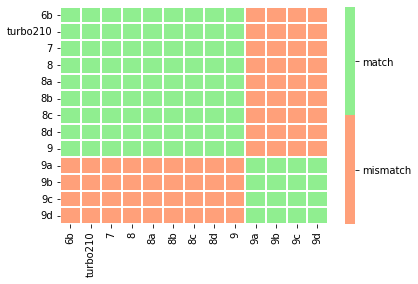

offset1: 264 offset2: 263


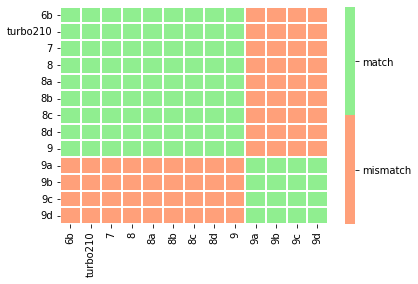

offset1: 264 offset2: 260


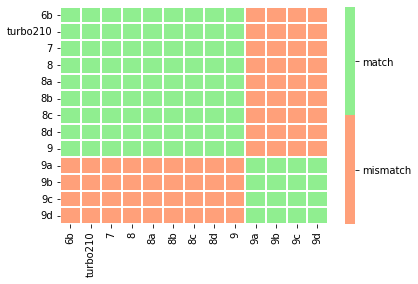

offset1: 264 offset2: 258


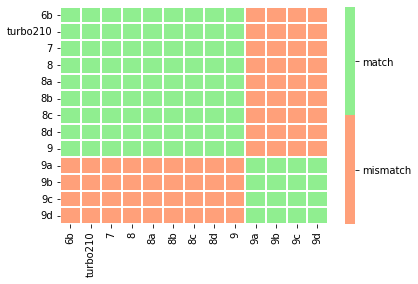

offset1: 264 offset2: 257


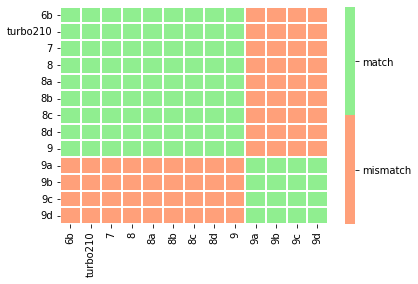

offset1: 263 offset2: 264


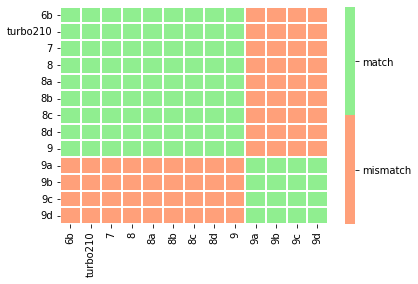

offset1: 263 offset2: 263


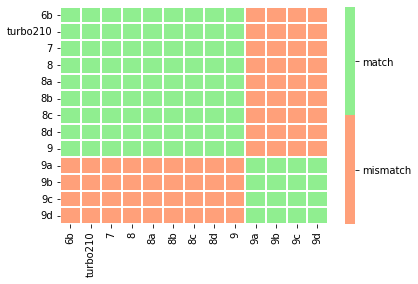

offset1: 263 offset2: 260


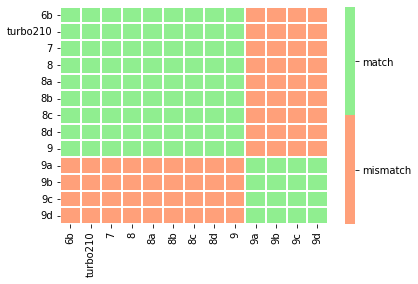

offset1: 263 offset2: 258


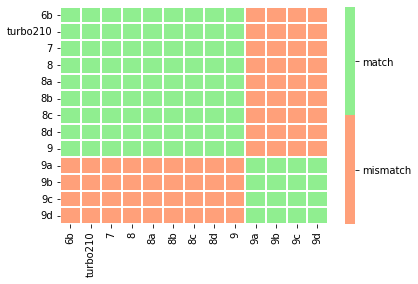

offset1: 263 offset2: 257


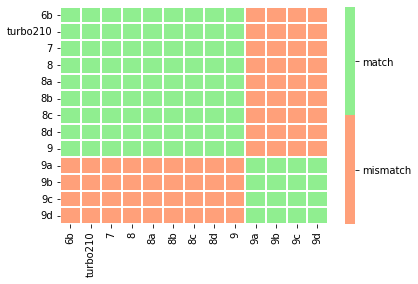

offset1: 260 offset2: 264


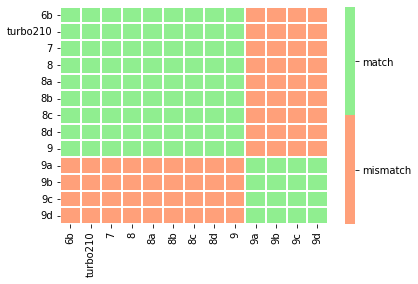

offset1: 260 offset2: 263


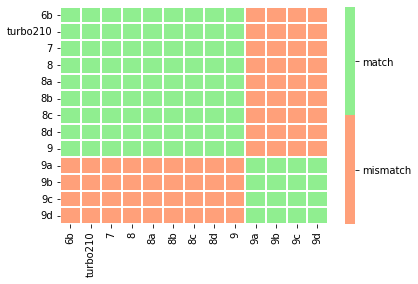

offset1: 260 offset2: 260


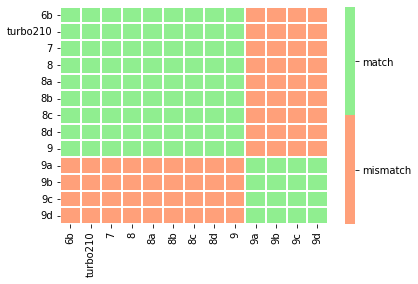

offset1: 260 offset2: 258


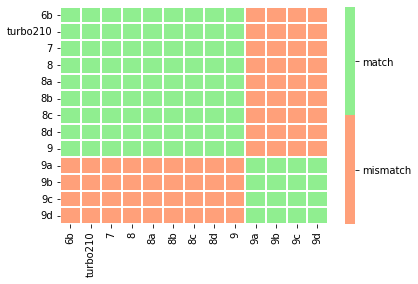

offset1: 260 offset2: 257


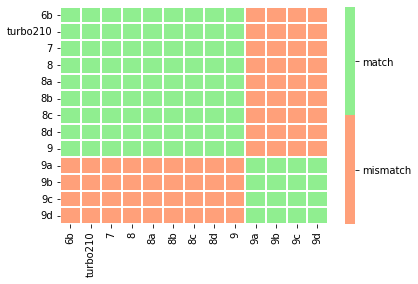

offset1: 258 offset2: 264


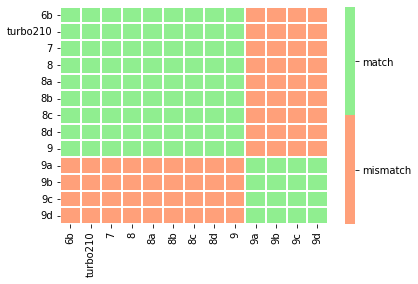

offset1: 258 offset2: 263


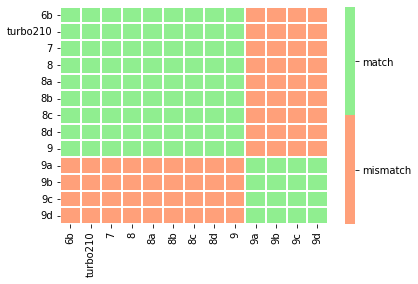

offset1: 258 offset2: 260


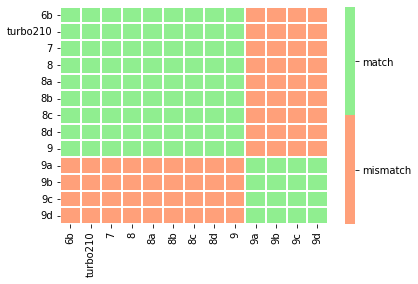

offset1: 258 offset2: 258


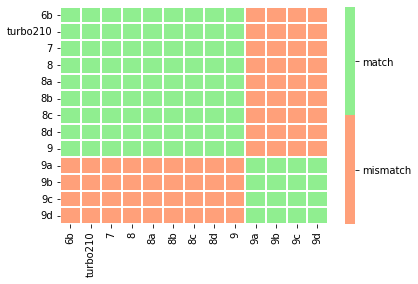

offset1: 258 offset2: 257


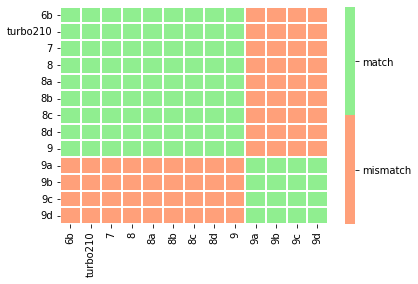

offset1: 257 offset2: 264


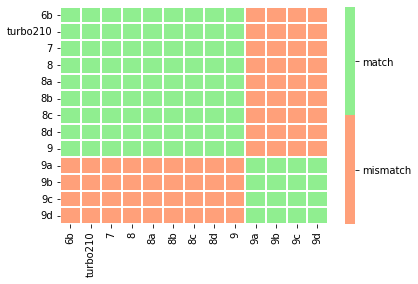

offset1: 257 offset2: 263


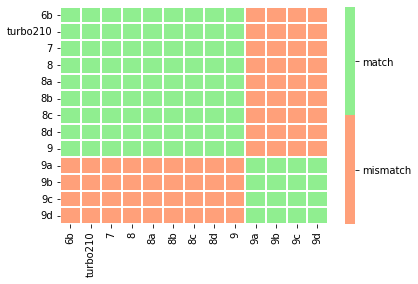

offset1: 257 offset2: 260


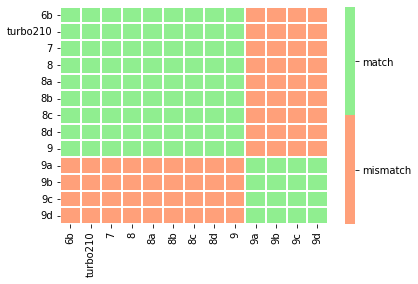

offset1: 257 offset2: 258


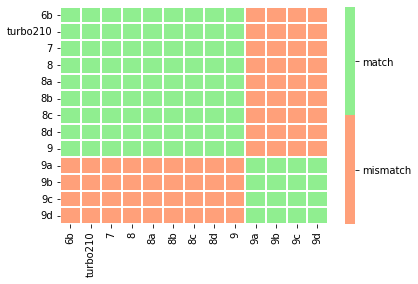

offset1: 257 offset2: 257


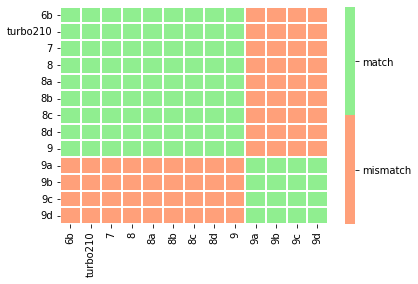

offset1: 264 offset2: 264
 -> 2 classes: ['9a', '9b', '9c', '9d'] ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9']
offset1: 264 offset2: 263
 -> 2 classes: ['9a', '9b', '9c', '9d'] ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9']
offset1: 264 offset2: 260
 -> 2 classes: ['9a', '9b', '9c', '9d'] ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9']
offset1: 264 offset2: 258
 -> 2 classes: ['9a', '9b', '9c', '9d'] ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9']
offset1: 264 offset2: 257
 -> 2 classes: ['9a', '9b', '9c', '9d'] ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9']
offset1: 263 offset2: 264
 -> 2 classes: ['9a', '9b', '9c', '9d'] ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9']
offset1: 263 offset2: 263
 -> 2 classes: ['9a', '9b', '9c', '9d'] ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9']
offset1: 263 offset2: 260
 -> 2 classes: ['9a', '9b', '9c', '9d'] ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9']
offset1:

In [18]:
# cast to dataframe
images_rgb_d = pd.DataFrame(images_rgb_d)

# convert to distance matrix
distmats_rgb_offset = convert_to_distmat(offsets, images_rgb_d)

# plot mismatching offsets
plot_mismatching_offsets(distmats_rgb_offset) 

# cluster offsets
clustering(distmats_rgb_offset)

### We produce differences !!!
Turns out, when we compress with 9d and decompress with other versions we produce differences. They appear from 9a, so there must have been some kind of changes.

In [19]:
offsets = np.array([8,7,4,2,1])+height_width
versions = ['6b','turbo210','7','8','8a','8b','8c','8d','9','9a','9b','9c','9d']
kw = {'samp_factor': ((1,1),(1,1),(1,1)), 'in_color_space': 'JCS_GRAYSCALE', 'qt': 75} # sampling factor

### 2. Systematic cropping with chroma subsampling - Alaska2 
#### 2.a Compression with chroma subsampling

We started by cropping 10 test images to 256 and offsets of 16, 15, 9, 8, 7, 3, 2, and 1.
We subsampled the images to 4x2x2.

After that we compressed the images with all available jpeg versions and decompressed with verson 9d, since earlier results demonstrated (...).

In [20]:
# iterate over all versions and crop images
offsets = np.array([16,15,9,8,7,3,2,1])+height_width
versions = ['6b','turbo210','7','8','8a','8b','8c','8d','9','9a','9b','9c','9d']
kw = {'samp_factor': ((2,2),(1,1),(1,1)), 'qt': 75, 'flags': ['DO_FANCY_UPSAMPLING']} # sampling factor
images_rgb_c = {'version': [], 'offset1': [],'offset2':[], 'image': []}

with tempfile.TemporaryDirectory() as tmp:
    
    # iterate versions
    for i,v_compress in enumerate(versions):
        
        # iterate offsets
        for offset1 in offsets:
            for offset2 in offsets:
                
                # cropping images 
                # alaska_cropped = alaska[:, :offset1, :offset2] #will be 10:offset:offset:3
                
                # cropp image from center
                center = tuple(s/2 for s in alaska.shape)
                x = int(center[2] - height_width/2)
                y = int(center[1] - height_width/2)
                alaska_cropped = alaska[:, y:y+offset1, x:offset2]
                
                # compressing each cropped image with version
                fnames = [str(Path(tmp) / f'{i}.jpeg') for i in range(alaska.shape[0])]
                with jpeglib.version(v_compress):                                            
                        [jpeglib.JPEG().write_spatial(fname,alaska_cropped[i],**kw) 
                         for i,fname in enumerate(fnames)]


                # decompress with single (arbitrary) version
                with jpeglib.version('9d'):
                    images_rgb_c['version'].append(v_compress)
                    images_rgb_c['offset1'].append(offset1)
                    images_rgb_c['offset2'].append(offset2)
                    images_rgb_c['image'].append(np.array([
                        jpeglib.JPEG(fname).read_spatial(flags=['DO_FANCY_UPSAMPLING']) for fname in fnames
                    ]))
                    

offset1: 272 offset2: 272


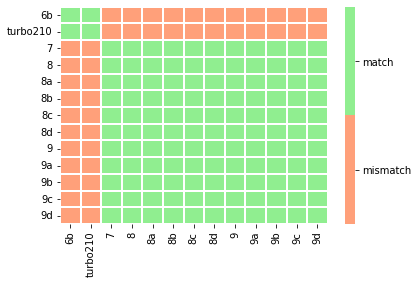

offset1: 272 offset2: 271


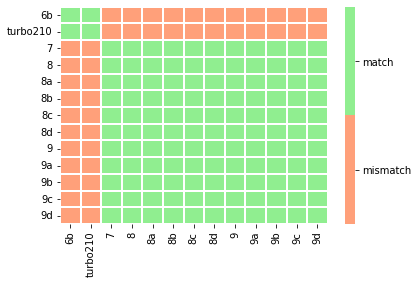

offset1: 272 offset2: 265


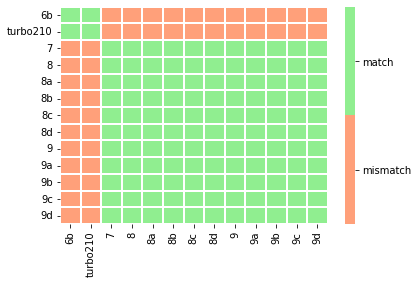

offset1: 272 offset2: 264


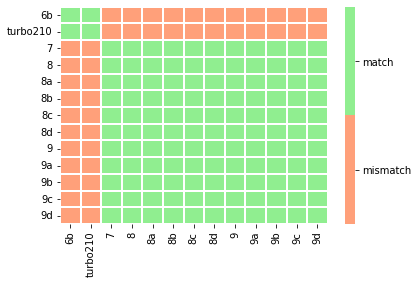

offset1: 272 offset2: 263


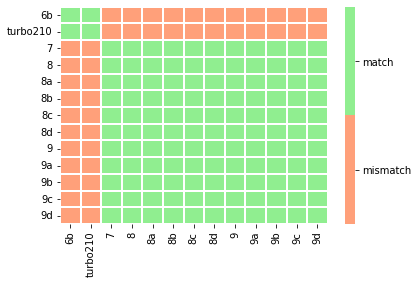

offset1: 272 offset2: 259


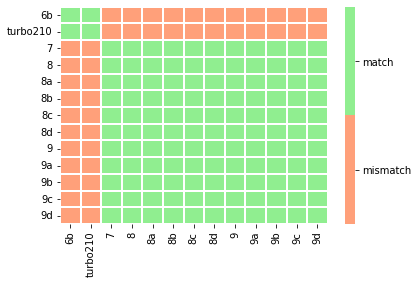

offset1: 272 offset2: 258


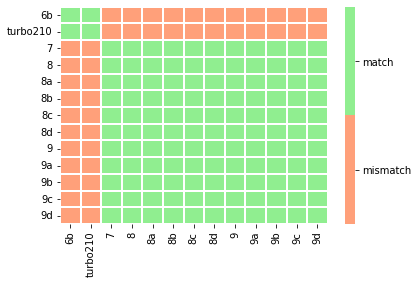

offset1: 272 offset2: 257


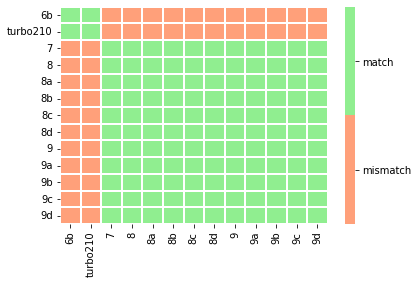

offset1: 271 offset2: 272


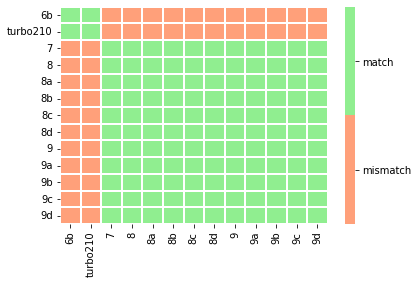

offset1: 271 offset2: 271


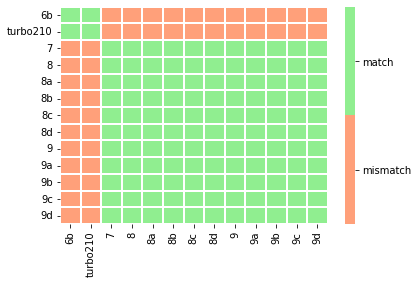

offset1: 271 offset2: 265


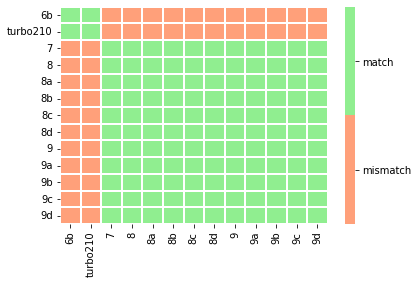

offset1: 271 offset2: 264


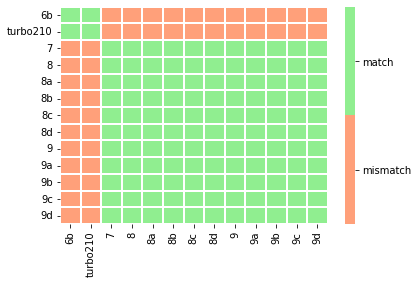

offset1: 271 offset2: 263


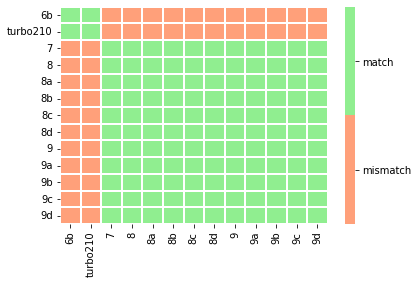

offset1: 271 offset2: 259


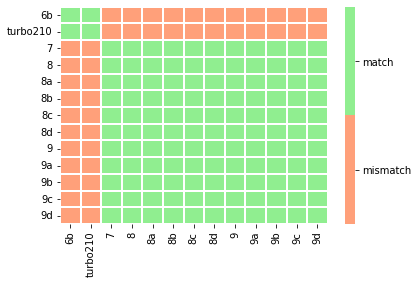

offset1: 271 offset2: 258


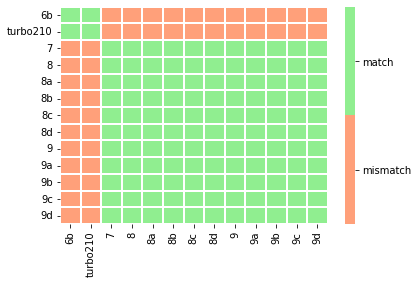

offset1: 271 offset2: 257


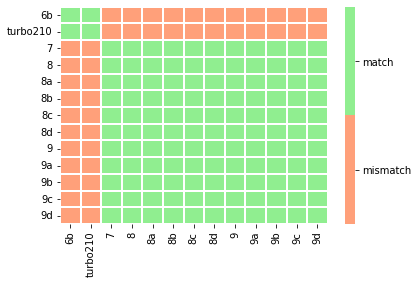

offset1: 265 offset2: 272


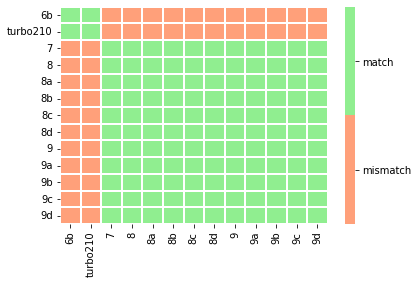

offset1: 265 offset2: 271


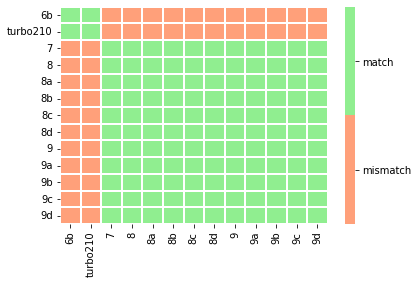

offset1: 265 offset2: 265


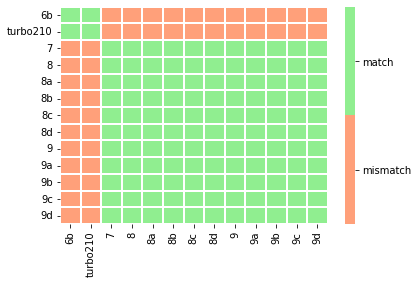

offset1: 265 offset2: 264


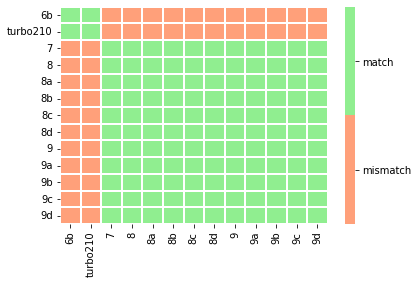

offset1: 265 offset2: 263


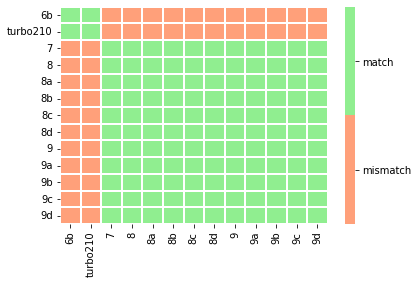

offset1: 265 offset2: 259


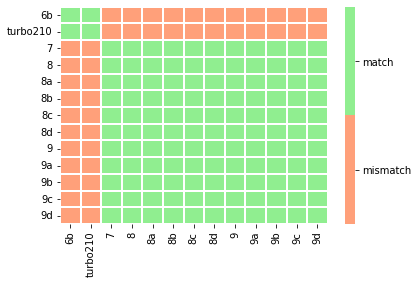

offset1: 265 offset2: 258


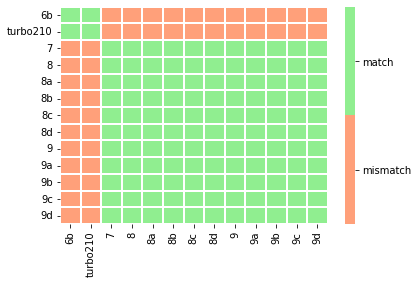

offset1: 265 offset2: 257


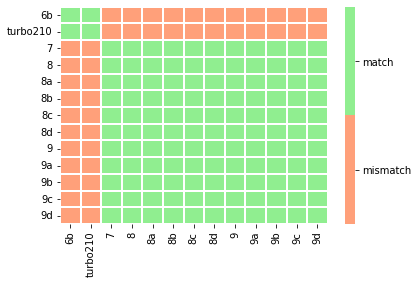

offset1: 264 offset2: 272


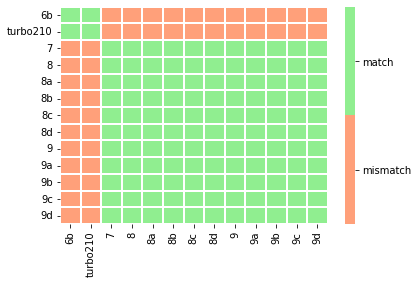

offset1: 264 offset2: 271


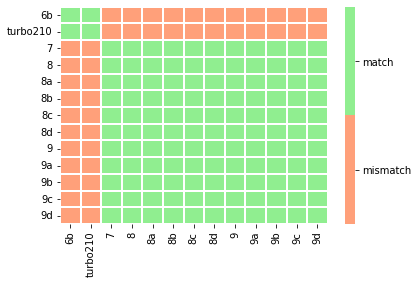

offset1: 264 offset2: 265


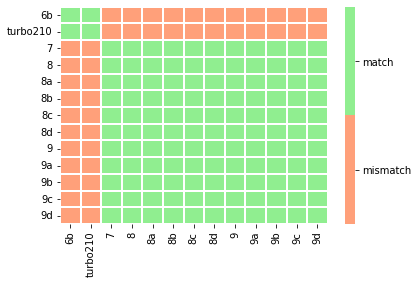

offset1: 264 offset2: 264


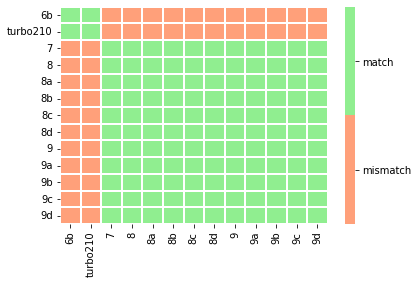

offset1: 264 offset2: 263


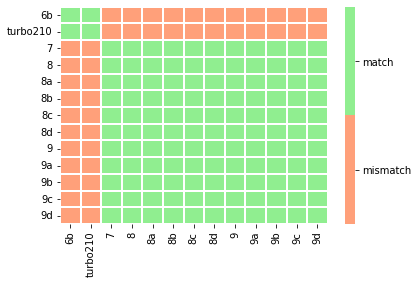

offset1: 264 offset2: 259


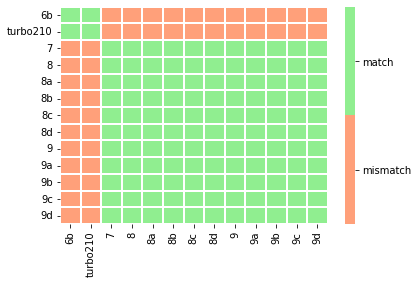

offset1: 264 offset2: 258


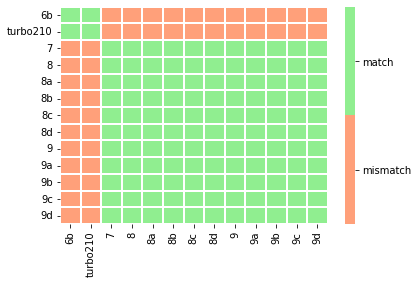

offset1: 264 offset2: 257


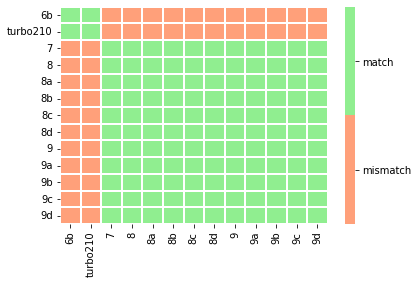

offset1: 263 offset2: 272


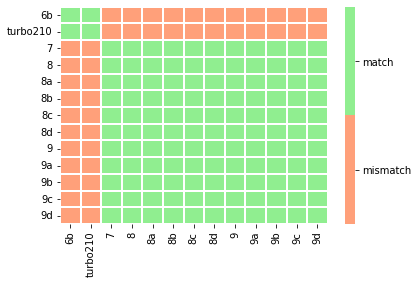

offset1: 263 offset2: 271


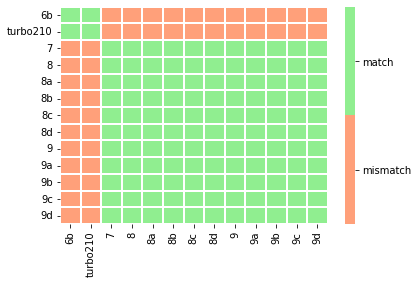

offset1: 263 offset2: 265


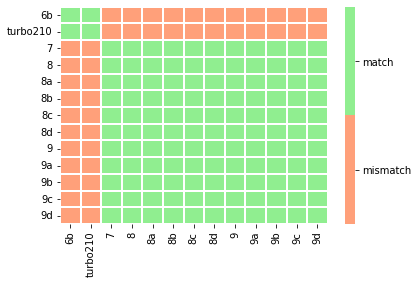

offset1: 263 offset2: 264


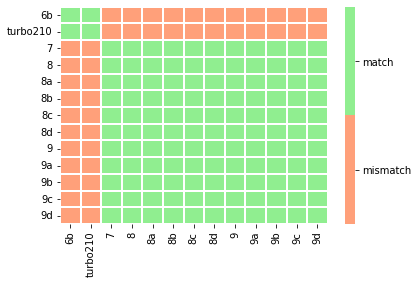

offset1: 263 offset2: 263


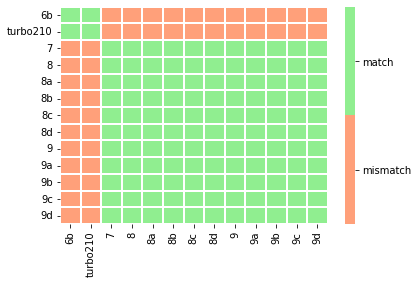

offset1: 263 offset2: 259


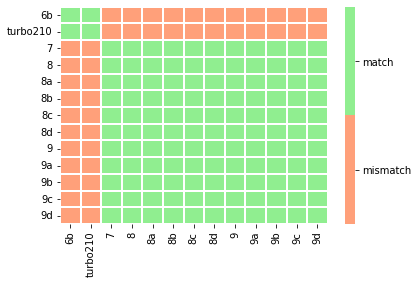

offset1: 263 offset2: 258


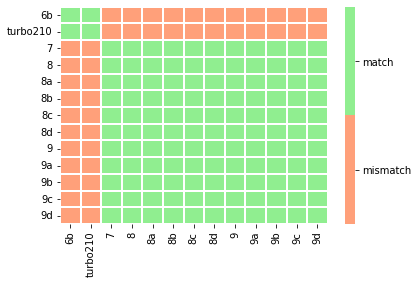

offset1: 263 offset2: 257


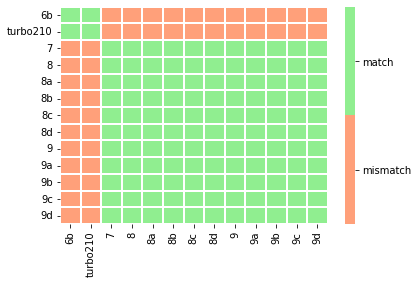

offset1: 259 offset2: 272


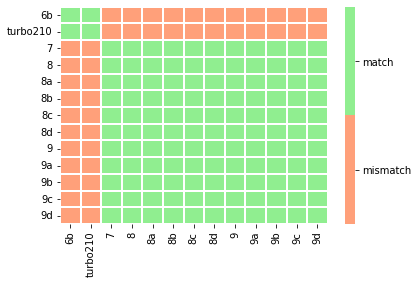

offset1: 259 offset2: 271


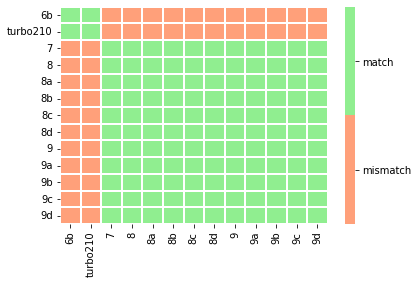

offset1: 259 offset2: 265


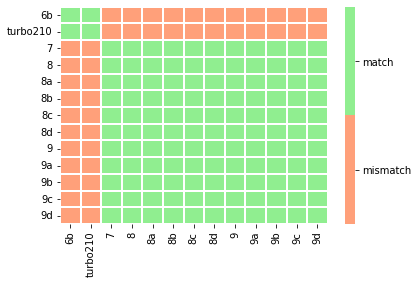

offset1: 259 offset2: 264


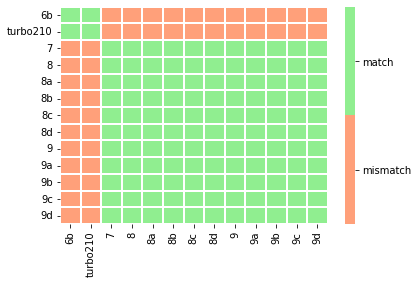

offset1: 259 offset2: 263


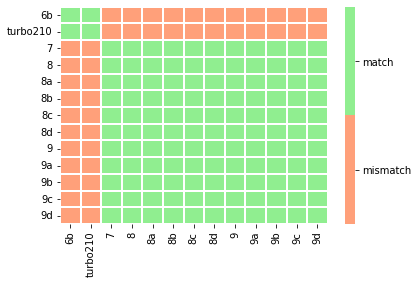

offset1: 259 offset2: 259


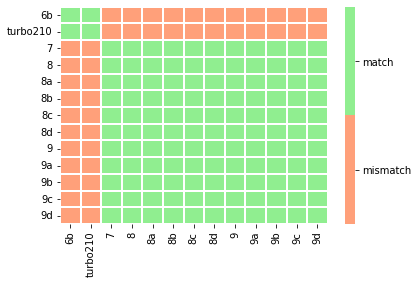

offset1: 259 offset2: 258


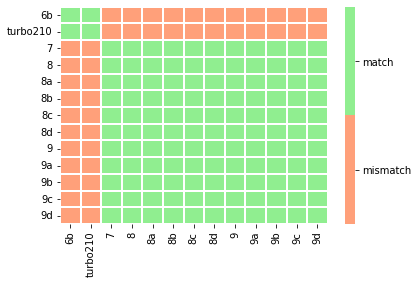

offset1: 259 offset2: 257


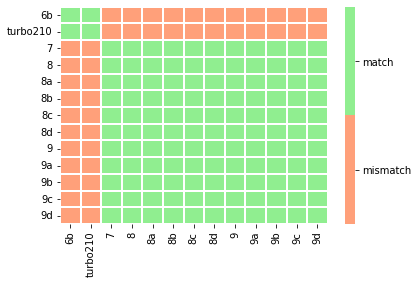

offset1: 258 offset2: 272


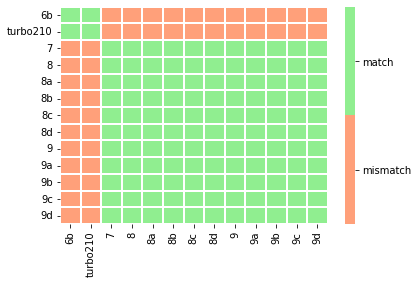

offset1: 258 offset2: 271


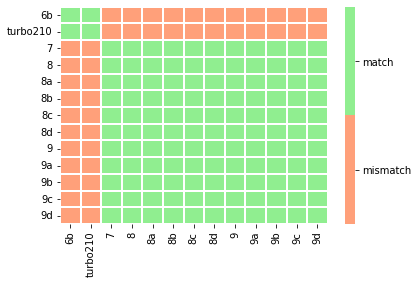

offset1: 258 offset2: 265


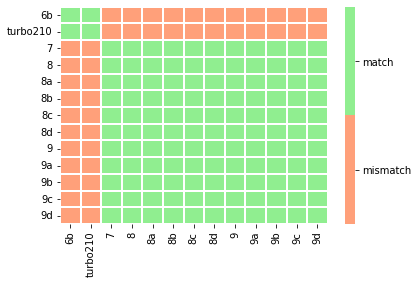

offset1: 258 offset2: 264


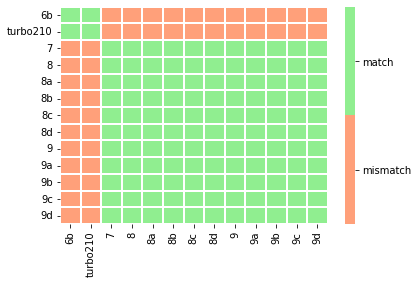

offset1: 258 offset2: 263


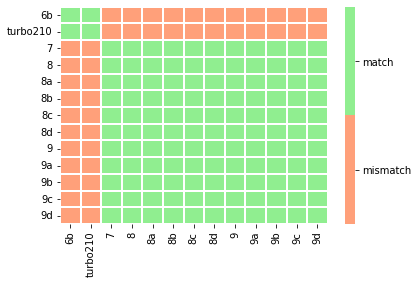

offset1: 258 offset2: 259


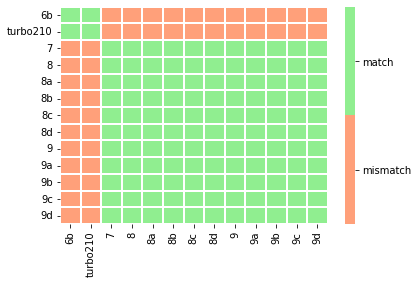

offset1: 258 offset2: 258


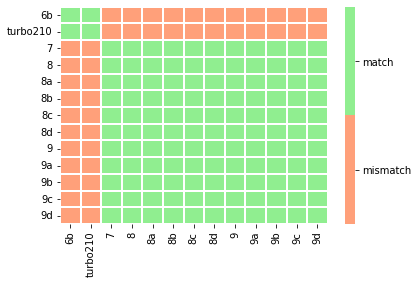

offset1: 258 offset2: 257


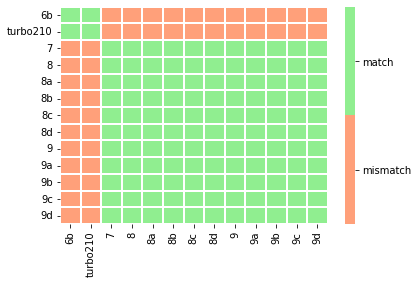

offset1: 257 offset2: 272


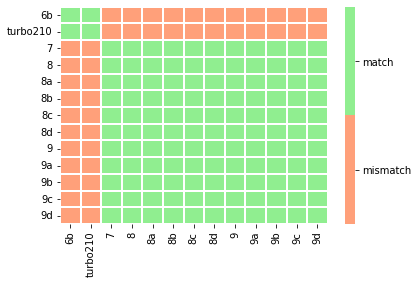

offset1: 257 offset2: 271


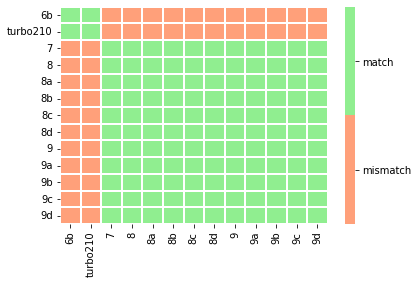

offset1: 257 offset2: 265


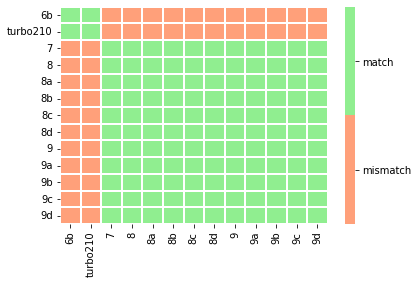

offset1: 257 offset2: 264


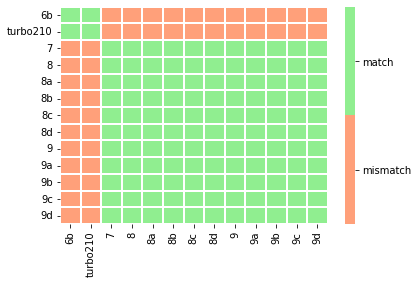

offset1: 257 offset2: 263


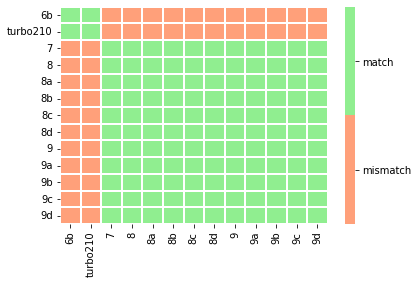

offset1: 257 offset2: 259


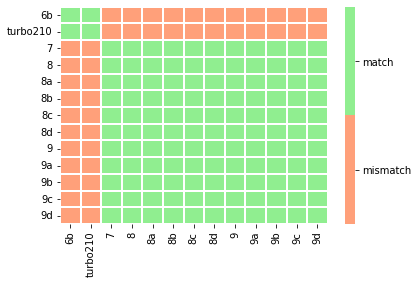

offset1: 257 offset2: 258


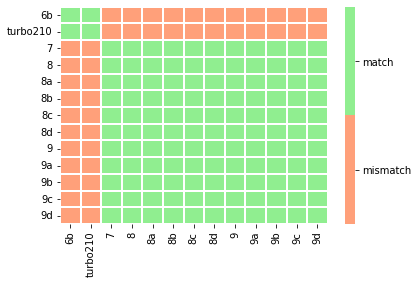

offset1: 257 offset2: 257


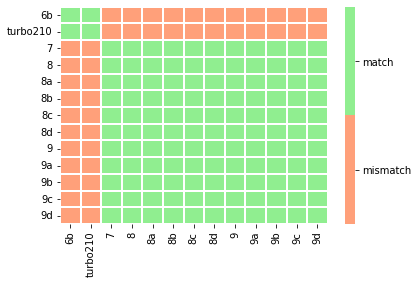

offset1: 272 offset2: 272
 -> 2 classes: ['7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['6b', 'turbo210']
offset1: 272 offset2: 271
 -> 2 classes: ['7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['6b', 'turbo210']
offset1: 272 offset2: 265
 -> 2 classes: ['7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['6b', 'turbo210']
offset1: 272 offset2: 264
 -> 2 classes: ['7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['6b', 'turbo210']
offset1: 272 offset2: 263
 -> 2 classes: ['7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['6b', 'turbo210']
offset1: 272 offset2: 259
 -> 2 classes: ['7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['6b', 'turbo210']
offset1: 272 offset2: 258
 -> 2 classes: ['7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['6b', 'turbo210']
offset1: 272 offset2: 257
 -> 2 classes: ['7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d'] ['6b', 'turbo210']
offset1:

In [21]:
# cast to dataframe
images_rgb_c = pd.DataFrame(images_rgb_c)

# convert to distance matrix
distmats_rgb_offset = convert_to_distmat(offsets, images_rgb_c)

# plot mismatching offsets
plot_mismatching_offsets(distmats_rgb_offset) 

# cluster offsets
clustering(distmats_rgb_offset)

#### 2.b Decompression with chroma subsampling
Now let's check if we produce differences when decompressing with all available jpeglib versions. 

In [22]:
offsets = np.array([16,15,9,8,7,3,2,1])+256
versions = ['6b','turbo210','7','8','8a','8b','8c','8d','9','9a','9b','9c','9d']
kw = {'samp_factor': ((2,2),(1,1),(1,1)), 'qt': 75, 'flags': ['DO_FANCY_UPSAMPLING']} # sampling factor
images_rgb_c = {'version': [], 'offset1': [],'offset2':[], 'image': []}

with tempfile.TemporaryDirectory() as tmp:
    
    # iterate versions
    for i,v_decompress in enumerate(versions):
        
        # iterate offsets
        for offset1 in offsets:
            for offset2 in offsets:
                
                # cropping images 
                alaska_cropped = alaska[:, :offset1, :offset2] #will be 10:offset:offset:3


offset1: 272 offset2: 272


/var/folders/l7/630hr2nx5d3b40lh2zrf65w80000gn/T/ipykernel_62451/2860341833.py:29: RuntimeWarning: Mean of empty slice.
  pixel_mismatch = lambda x1,x2: (np.abs(x1.astype(np.int32) - x2.astype(np.int32)) != 0).mean()
/opt/miniconda3/envs/ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/var/folders/l7/630hr2nx5d3b40lh2zrf65w80000gn/T/ipykernel_62451/2860341833.py:29: RuntimeWarning: Mean of empty slice.
  pixel_mismatch = lambda x1,x2: (np.abs(x1.astype(np.int32) - x2.astype(np.int32)) != 0).mean()
/opt/miniconda3/envs/ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/var/folders/l7/630hr2nx5d3b40lh2zrf65w80000gn/T/ipykernel_62451/2860341833.py:29: RuntimeWarning: Mean of empty slice.
  pixel_mismatch = lambda x1,x2: (np.abs(x1.astype(np.int32) - x2.astype(np.int32)) != 0).me

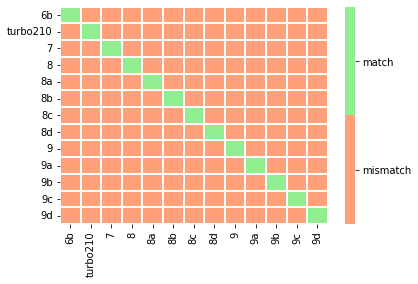

offset1: 272 offset2: 271


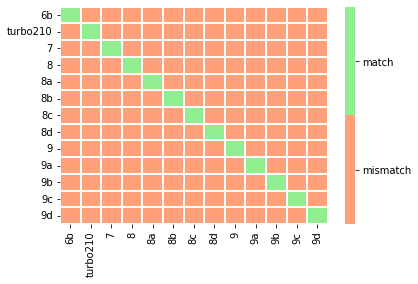

offset1: 272 offset2: 265


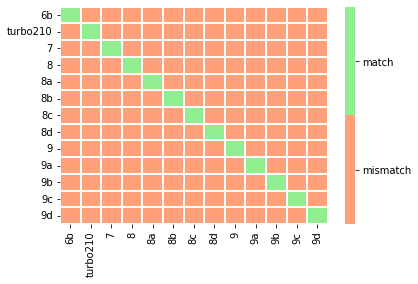

offset1: 272 offset2: 264


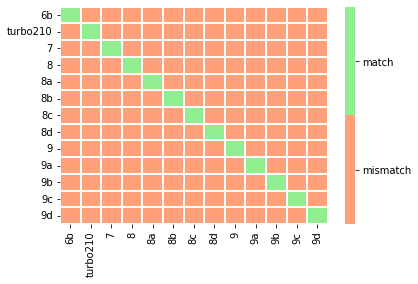

offset1: 272 offset2: 263


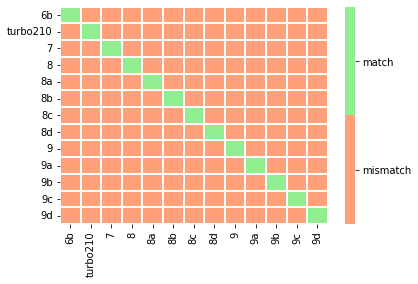

offset1: 272 offset2: 259


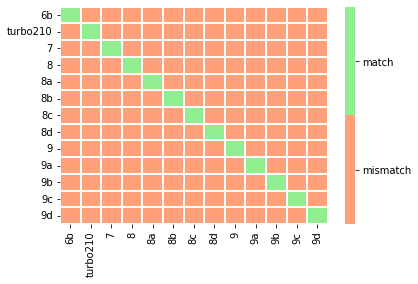

offset1: 272 offset2: 258


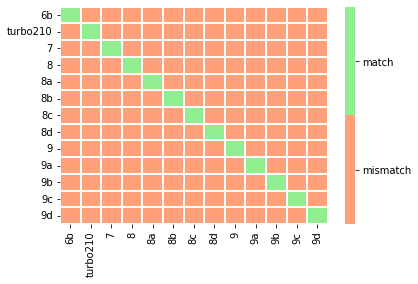

offset1: 272 offset2: 257


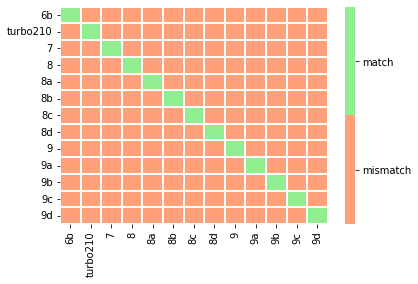

offset1: 271 offset2: 272


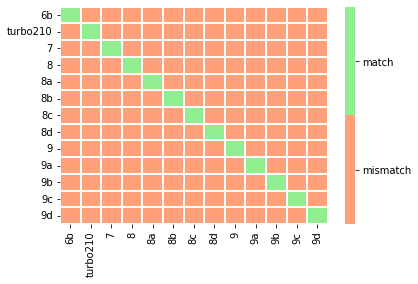

offset1: 271 offset2: 271


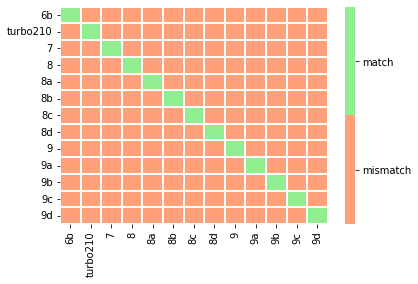

offset1: 271 offset2: 265


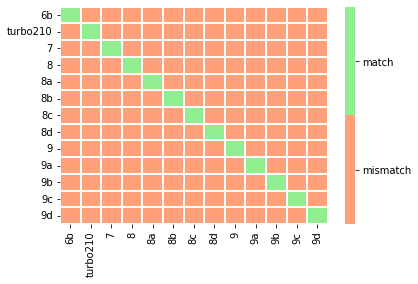

offset1: 271 offset2: 264


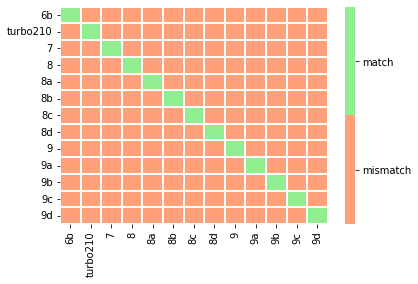

offset1: 271 offset2: 263


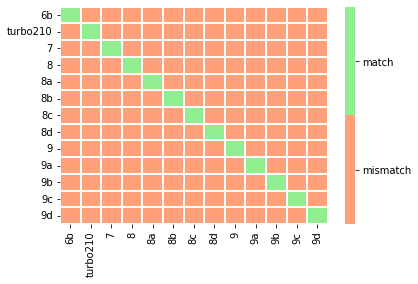

offset1: 271 offset2: 259


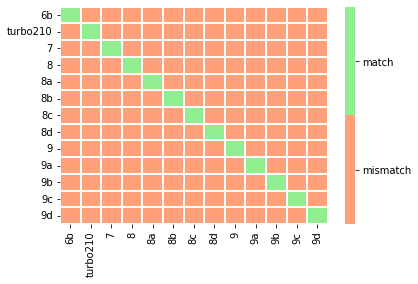

offset1: 271 offset2: 258


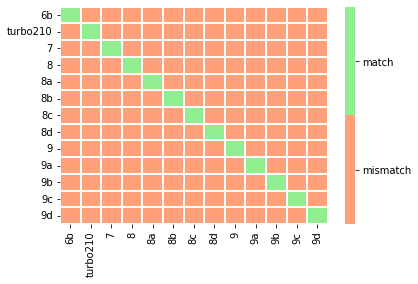

offset1: 271 offset2: 257


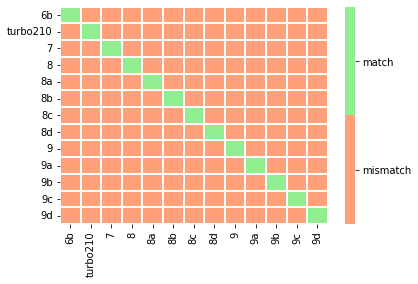

offset1: 265 offset2: 272


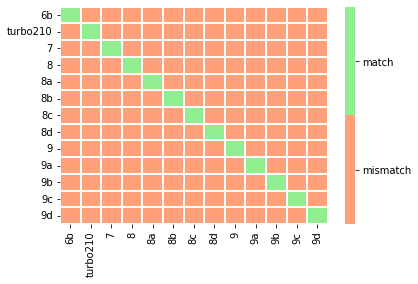

offset1: 265 offset2: 271


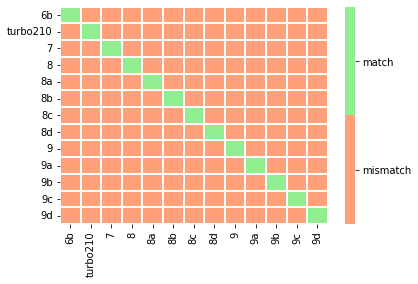

offset1: 265 offset2: 265


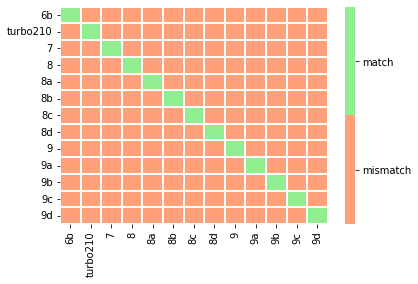

offset1: 265 offset2: 264


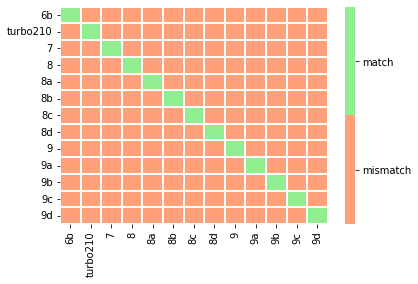

offset1: 265 offset2: 263


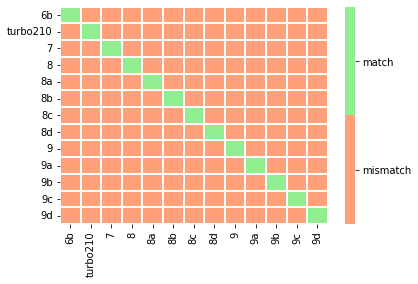

offset1: 265 offset2: 259


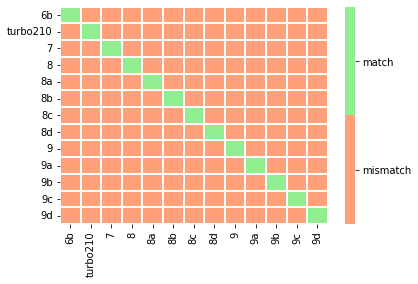

offset1: 265 offset2: 258


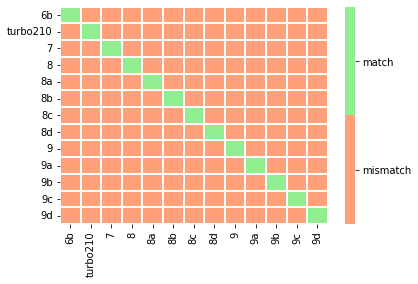

offset1: 265 offset2: 257


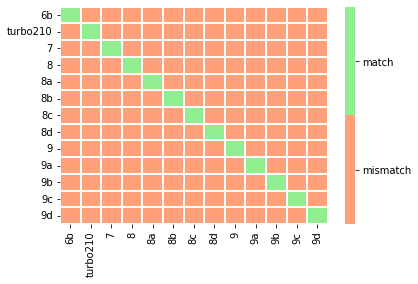

offset1: 264 offset2: 272


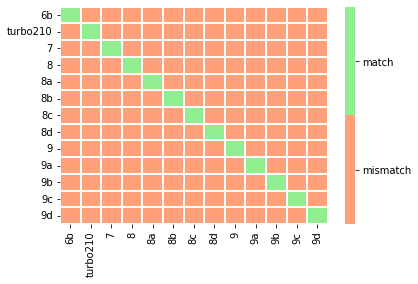

offset1: 264 offset2: 271


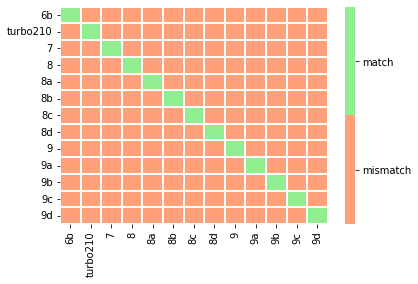

offset1: 264 offset2: 265


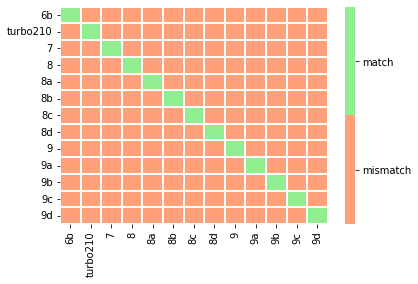

offset1: 264 offset2: 264


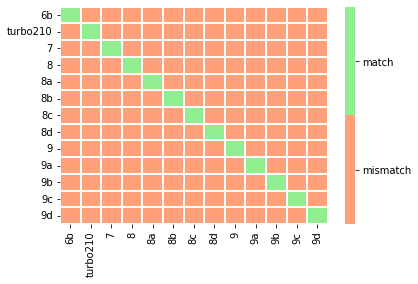

offset1: 264 offset2: 263


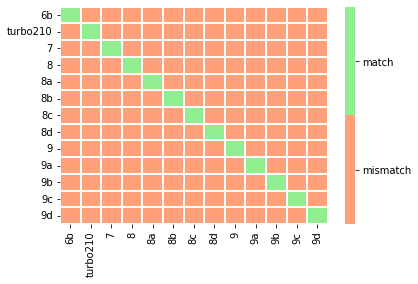

offset1: 264 offset2: 259


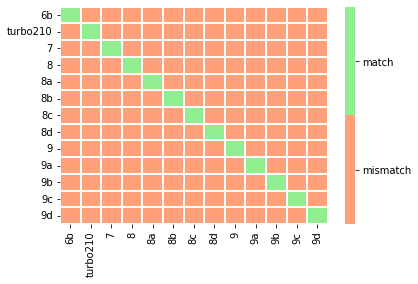

offset1: 264 offset2: 258


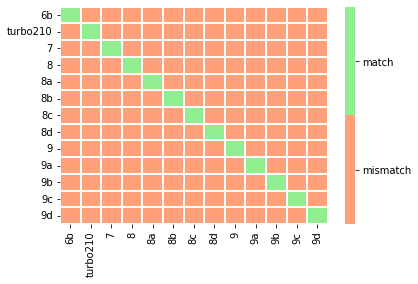

offset1: 264 offset2: 257


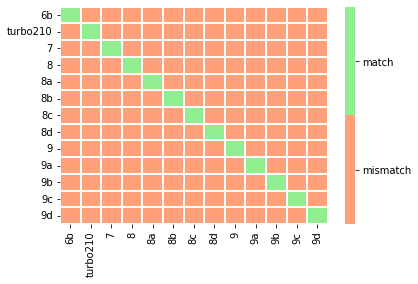

offset1: 263 offset2: 272


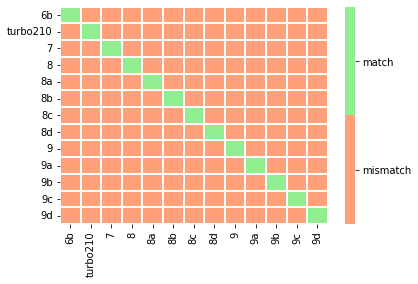

offset1: 263 offset2: 271


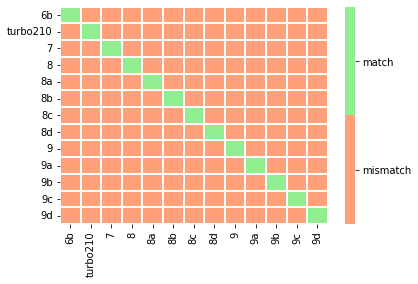

offset1: 263 offset2: 265


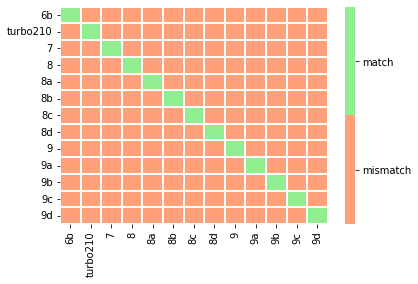

offset1: 263 offset2: 264


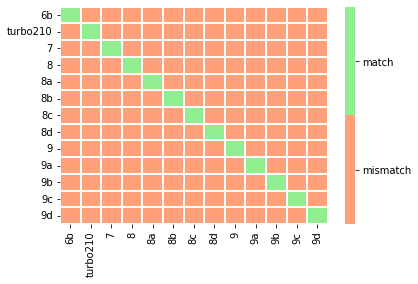

offset1: 263 offset2: 263


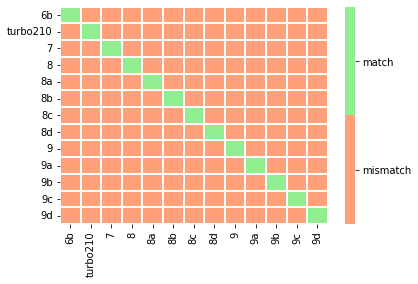

offset1: 263 offset2: 259


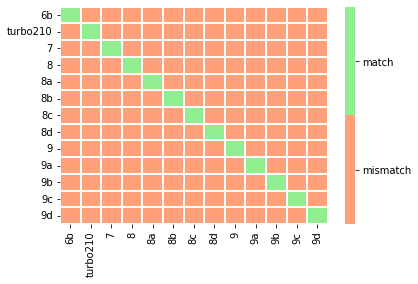

offset1: 263 offset2: 258


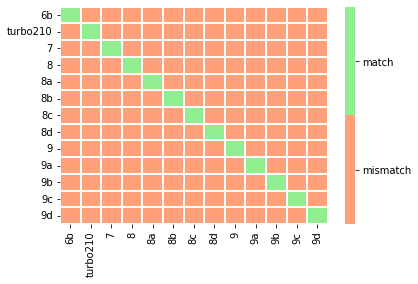

offset1: 263 offset2: 257


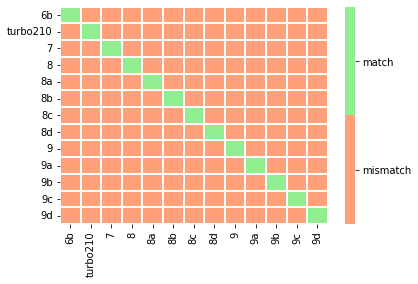

offset1: 259 offset2: 272


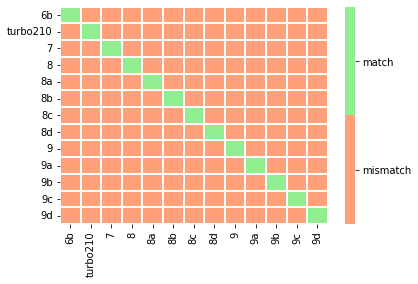

offset1: 259 offset2: 271


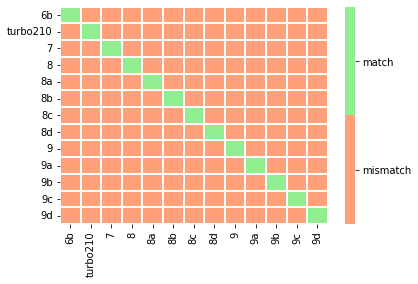

offset1: 259 offset2: 265


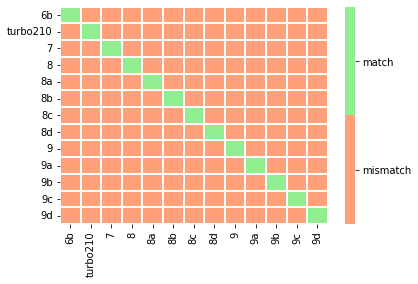

offset1: 259 offset2: 264


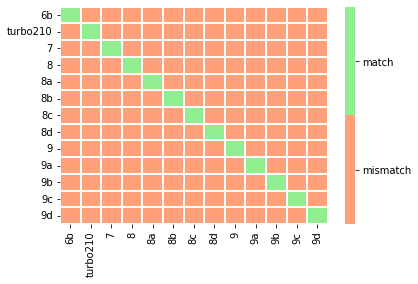

offset1: 259 offset2: 263


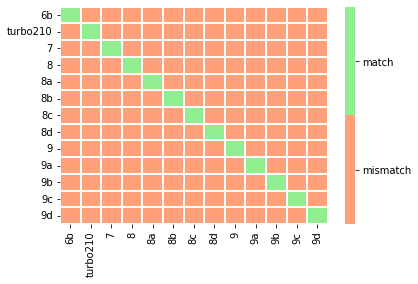

offset1: 259 offset2: 259


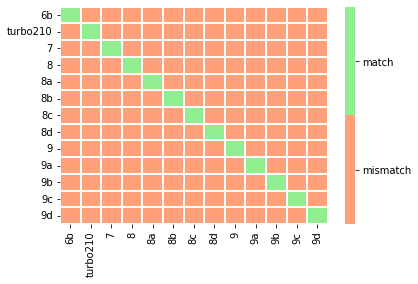

offset1: 259 offset2: 258


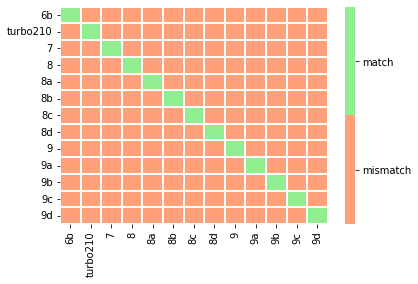

offset1: 259 offset2: 257


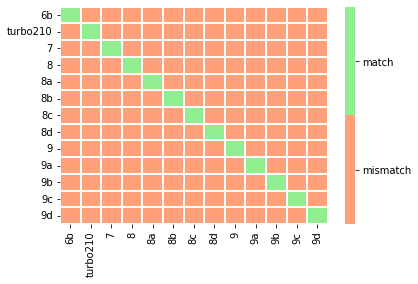

offset1: 258 offset2: 272


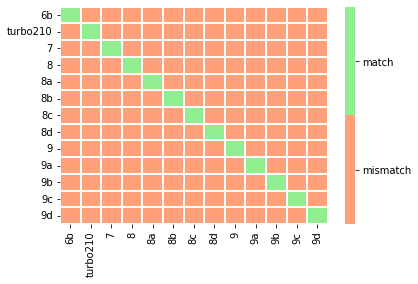

offset1: 258 offset2: 271


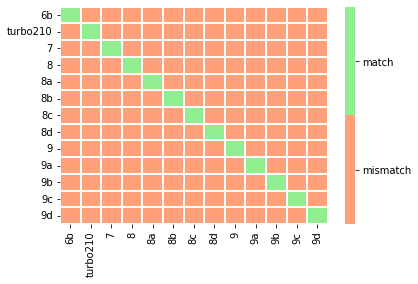

offset1: 258 offset2: 265


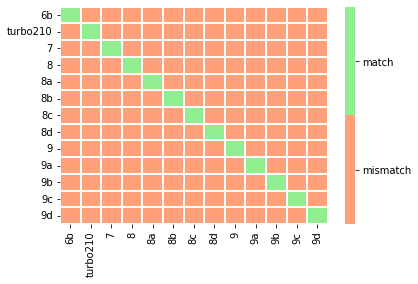

offset1: 258 offset2: 264


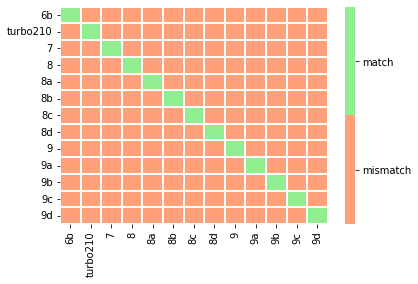

offset1: 258 offset2: 263


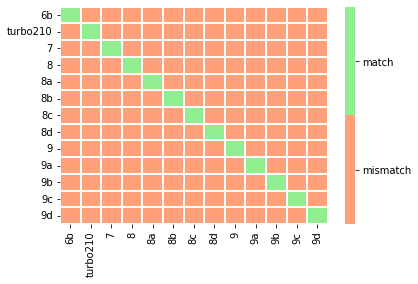

offset1: 258 offset2: 259


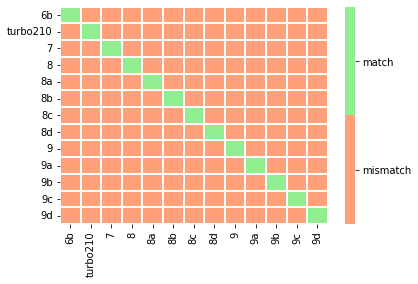

offset1: 258 offset2: 258


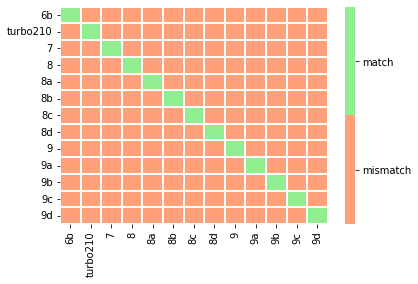

offset1: 258 offset2: 257


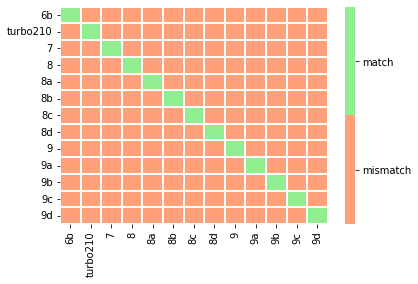

offset1: 257 offset2: 272


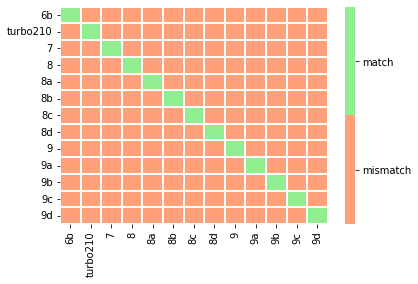

offset1: 257 offset2: 271


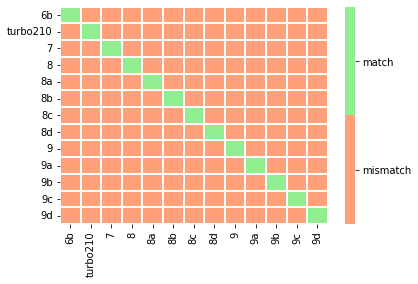

offset1: 257 offset2: 265


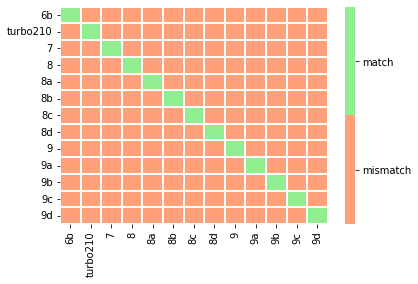

offset1: 257 offset2: 264


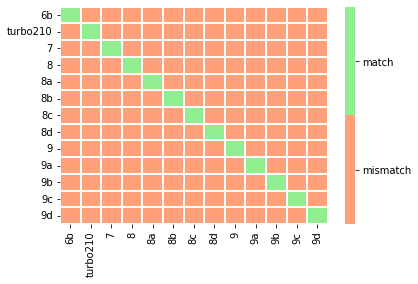

offset1: 257 offset2: 263


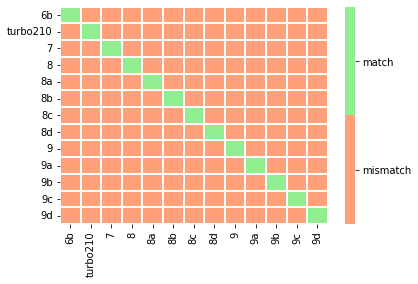

offset1: 257 offset2: 259


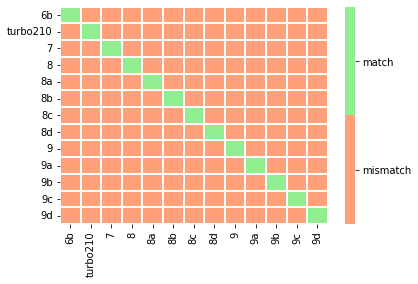

offset1: 257 offset2: 258


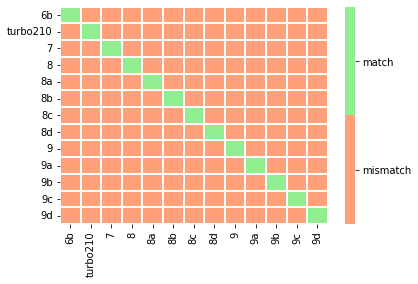

offset1: 257 offset2: 257


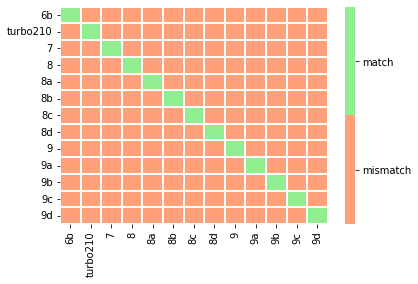

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [23]:
# cast to dataframe
images_rgb_c = pd.DataFrame(images_rgb_c)

# convert to distance matrix
distmats_rgb_offset = convert_to_distmat(offsets, images_rgb_c)

# plot mismatching offsets
plot_mismatching_offsets(distmats_rgb_offset) 

# cluster offsets
clustering(distmats_rgb_offset)

#### 2.b Decompression with chroma subsampling
Now let's check if we produce differences when decompressing with all available jpeglib versions. 

In [ ]:
offsets = np.array([16,15,9,8,7,3,2,1])+height_width
versions = ['6b','turbo210','7','8','8a','8b','8c','8d','9','9a','9b','9c','9d']
kw = {'samp_factor': ((2,2),(1,1),(1,1)), 'qt': 75, 'flags': ['DO_FANCY_UPSAMPLING']} # sampling factor
images_rgb_c = {'version': [], 'offset1': [],'offset2':[], 'image': []}

with tempfile.TemporaryDirectory() as tmp:
    
    # iterate versions
    for i,v_decompress in enumerate(versions):
        
        # iterate offsets
        for offset1 in offsets:
            for offset2 in offsets:
                
                # cropping images 
                # alaska_cropped = alaska[:, :offset1, :offset2] #will be 10:offset:offset:3
                
                # cropp image from center
                center = tuple(s/2 for s in alaska.shape)
                x = int(center[2] - height_width/2)
                y = int(center[1] - height_width/2)
                alaska_cropped = alaska[:, y:y+offset1, x:offset2]

                # compressing each cropped image with version
                fnames = [str(Path(tmp) / f'{i}.jpeg') for i in range(alaska.shape[0])]
                with jpeglib.version('9d'):                                                            
                    [jpeglib.JPEG().write_spatial(fname,alaska_cropped[i],**kw) 
                     for i,fname in enumerate(fnames)]

                # decompress with single (arbitrary) version
                with jpeglib.version(v_decompress):
                    images_rgb_c['version'].append(v_decompress)
                    images_rgb_c['offset1'].append(offset1)
                    images_rgb_c['offset2'].append(offset2)
                    images_rgb_c['image'].append(np.array([
                        jpeglib.JPEG(fname).read_spatial(flags=['DO_FANCY_UPSAMPLING']) for fname in fnames
                    ]))

In [ ]:
# cast to dataframe
images_rgb_c = pd.DataFrame(images_rgb_c)

# convert to distance matrix
distmats_rgb_offset = convert_to_distmat(offsets, images_rgb_c)

# plot mismatching offsets
plot_mismatching_offsets(distmats_rgb_offset) 

# cluster offsets
clustering(distmats_rgb_offset)

## 